In [2]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torchvision.transforms as transforms
from tqdm import tqdm
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
import netCDF4 as nc
import scipy.io as sio
import pandas as pd
import imageio

Random Seed:  999


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
for i in range(0,80):
  for k in range(0,2):
    if i < 10:

      dat1 = pd.read_csv(f'/content/drive/MyDrive/DATA/coarse_pandas/OrszagTang-coarse-grid-param{k}-idx-0000{i}-time-idx-{i}.csv')
    else:
      dat1 = pd.read_csv(f'/content/drive/MyDrive/DATA/coarse_pandas/OrszagTang-coarse-grid-param{k}-idx-000{i}-time-idx-{i}.csv')
    dat1 = dat1.drop(columns=['Unnamed: 0','rho'])
    data1 = np.array(dat1)
    a = data1.reshape(200,200,3)
    imageio.imwrite(f'/content/drive/MyDrive/coarse_pic//OrszagTang-coarse-grid-param{k}-idx-00000-time-idx-{i}.jpg',a)
   # plt.savefig(f'/content/drive/MyDrive/coarse_pic//OrszagTang-coarse-grid-param{k}-idx-00000-time-idx-{i}.jpg',a)

In [ ]:
for i in range(0,80):
  for k in range(0,2):
    if i < 10:

      dat1 = pd.read_csv(f'/content/drive/MyDrive/DATA/fine_pandas/OrszagTang-fine-grid-param{k}-idx-0000{i}-time-idx-{i}.csv')
    else:
      dat1 = pd.read_csv(f'/content/drive/MyDrive/DATA/fine_pandas/OrszagTang-fine-grid-param{k}-idx-000{i}-time-idx-{i}.csv')
    dat1 = dat1.drop(columns=['Unnamed: 0','rho'])
    data1 = np.array(dat1)
    a = data1.reshape(400,400,3)
    new_a = np.resize(a,(200,200,3))
    imageio.imwrite(f'/content/drive/MyDrive/fine_pic//OrszagTang-fine-grid-param{k}-idx-00000-time-idx-{i}.jpg',new_a)
  #  plt.savefig(f'/content/drive/MyDrive/fine_pic//OrszagTang-fine-grid-param{k}-idx-00000-time-idx-{i}.jpg')

In [32]:
new_image = np.resize(a,(200,200,3))

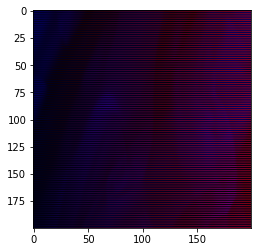

In [33]:
#a = data1.reshape(400,400,3)
plt.imshow(new_image)

In [34]:
import zipfile
#file_location = '/content/drive/MyDrive/orszag.zip'
!unzip -u "/content/drive/MyDrive/orszag.zip" -d "/content/drive/My Drive/DATA"

Archive:  /content/drive/MyDrive/orszag.zip


In [36]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [37]:
def save_some_examples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5  # remove normalization#
        save_image(y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        if epoch == 1:
            save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
    gen.train()


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [38]:
transform_only_input = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.ToTensor(),
      #  transforms.RandomHorizontalFlip(p=0.5),
     #   transforms.ColorJitter(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
     
    ]
)

transform_only_mask = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        
    
    ]
)

# Model initiation

In [39]:
import torch
import torch.nn as nn


class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(2,2),padding=1,  bias=False)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, kernel_size=(2,2),padding=1 , bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),)
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(features * 2, features * 4, down=True, act="leaky", use_dropout=False)
        self.down3 = Block(features * 4, features * 8, down=True, act="leaky", use_dropout=False)
        self.down4 = Block(features * 8, features * 8, down=True, act="leaky", use_dropout=False)
        self.down5 = Block(features * 8, features * 8, down=True, act="leaky", use_dropout=False)
        self.down6 = Block(features * 8, features * 8, down=True, act="leaky", use_dropout=False)
        self.bottleneck = nn.Sequential(nn.Conv2d(features * 8, features * 8, 4, 1, 2), nn.ReLU())


        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True)
        self.up3 = Block(features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True)
        self.up4 = Block(features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False)
        self.up5 = Block(features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False)
        self.up6 = Block(features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False)
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),nn.Tanh(),)

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))




In [40]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, 2, stride, bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels * 2,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature

        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            ),
        )

        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        x = self.model(x)
        return x




In [41]:
b = Generator()
b

Generator(
  (initial_down): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (down1): Block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down2): Block(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down3): Block(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentu

In [42]:
a = Discriminator()
a

Discriminator(
  (initial): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (model): Sequential(
    (0): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (2): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope

In [43]:
class MapDataset(Dataset):
    def __init__(self, root_dir,target_dir):
        self.root_dir = root_dir
        self.target_dir = target_dir
        self.list_files = os.listdir(self.root_dir)
        self.list_files_target = os.listdir(self.target_dir)

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        img_file = self.list_files[index]
        img_file_target = self.list_files_target[index]
        img_path = os.path.join(self.root_dir, img_file)
        img_path_target = os.path.join(self.target_dir, img_file_target)
       
        input_image = np.array(Image.open(img_path))
        target_image = np.array(Image.open(img_path_target))
        

 #       augmentations = both_transform(image=input_image, image0=target_image)
     

     #   input_image = transform_only_input(image=input_image)["image"]
      #  target_image = transform_only_mask(image=target_image)["image"]
        input_image = transform_only_input(input_image)
        target_image = transform_only_mask(target_image)



        return input_image, target_image

In [54]:
#TRAIN_DIR = "/content/drive/MyDrive/coarse_grid/"
#VAL_DIR = "/content/drive/MyDrive/fine_grid/"

TRAIN_DIR = "/content/drive/MyDrive/coarse_pic"
VAL_DIR = "/content/drive/MyDrive/fine_pic"
BATCH_SIZE = 12
LEARNING_RATE = 1e-3
NUM_WORKERS = 2
NUM_EPOCHS = 100
CHECKPOINT_DISC = "disc2.pth.tar"
CHECKPOINT_GEN = "gen2.pth.tar"
gen_weights = "gen_weights2.pt.tar"
disc_weights = "disc_weights2.pt.tar"
LOAD_MODEL=False
SAVE_MODEL = True
loss_disc = []
loss_gen = []
def train_fn(
    disc, gen, loader, opt_disc, opt_gen, l1_loss, bce, g_scaler, d_scaler,
learning_rate):
    loop = tqdm(loader, leave=True)



    for idx, (x, y) in enumerate(loop):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        # Train Discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            D_real = disc(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake = disc(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2
            loss_disc.append(D_loss.cpu().detach().numpy())

        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generator
        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1_loss(y_fake, y) * 100
            G_loss = G_fake_loss + L1
            loss_gen.append(G_loss.cpu().detach().numpy())

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 10 == 0:
            loop.set_postfix(
                D_real=torch.sigmoid(D_real).mean().item(),
                D_fake=torch.sigmoid(D_fake).mean().item(),
            )


def main():
    disc = Discriminator(in_channels=3).to(DEVICE)
    gen = Generator(in_channels=3, features=64).to(DEVICE)
    opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE , betas=(0.5, 0.999),)
    opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE , betas=(0.5, 0.999))
    BCE = nn.BCEWithLogitsLoss()
    L1_LOSS = nn.L1Loss()

    if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE,
        )

    train_dataset = MapDataset(root_dir=TRAIN_DIR,target_dir=VAL_DIR)
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
    )
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()
    val_dataset = MapDataset(root_dir=VAL_DIR,target_dir=VAL_DIR)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    for epoch in range(NUM_EPOCHS):
        train_fn(
            disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler,
        LEARNING_RATE)

        if SAVE_MODEL and epoch % 5 == 0:
            torch.save(gen.state_dict(), gen_weights)
            torch.save(disc.state_dict(),disc_weights)
            save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
            save_checkpoint(disc, opt_disc, filename=CHECKPOINT_DISC)

    #    save_some_examples(gen, val_loader, epoch, folder="evaluation")


In [55]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    5024 MB |    8676 MB |  121741 MB |  116717 MB |\n|       from large pool |    5013 MB |    8658 MB |  121546 MB |  116532 MB |\n|       from small pool |      10 MB |      22 MB |     195 MB |     184 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |    5024 MB |    8676 MB |  121741 MB |  116717 MB |\n|       from large pool |    5013 MB |    8658 MB |

In [56]:
if __name__ == "__main__":
    dataset = MapDataset(TRAIN_DIR,VAL_DIR)

    loader = DataLoader(dataset, batch_size=BATCH_SIZE)
  #  for x, y in loader:
    #    print(x.shape)
    #    save_image(x, "x.png")
    #    save_image(y, "y.png")
    #    import sys
    #    sys.exit()

In [57]:
torch.cuda.is_available()

True

In [58]:
if __name__ == "__main__":
    main()

100%|██████████| 14/14 [00:28<00:00,  2.03s/it, D_fake=0.186, D_real=0.728]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 14/14 [00:28<00:00,  2.03s/it, D_fake=0.541, D_real=0.512]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 14/14 [00:28<00:00,  2.03s/it, D_fake=0.295, D_real=0.707]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 14/14 [00:28<00:00,  2.03s/it, D_fake=0.172, D_real=0.832]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 14/14 [00:28<00:00,  2.03s/it, D_fake=0.197, D_real=0.216]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 14/14 [00:28<00:00,  2.03s/it, D_fake=0.47, D_real=0.366]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 14/14 [00:28<00:00,  2.03s/it, D_fake=0.064, D_real=0.872]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 14/14 [00:28<00:00,  2.03s/it, D_fake=0.0518, D_real=0.929]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 14/14 [00:28<00:00,  2.03s/it, D_fake=0.0801, D_real=0.868]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 14/14 [00:28<00:00,  2.03s/it, D_fake=0.0159, D_real=0.764]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 14/14 [00:28<00:00,  2.03s/it, D_fake=0.00764, D_real=0.961]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 14/14 [00:28<00:00,  2.03s/it, D_fake=0.0193, D_real=0.948]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 14/14 [00:28<00:00,  2.03s/it, D_fake=0.00349, D_real=0.985]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 14/14 [00:28<00:00,  2.03s/it, D_fake=0.00969, D_real=0.997]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 14/14 [00:28<00:00,  2.03s/it, D_fake=0.0853, D_real=0.877]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 14/14 [00:28<00:00,  2.03s/it, D_fake=0.042, D_real=0.989]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 14/14 [00:28<00:00,  2.03s/it, D_fake=0.00718, D_real=0.995]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 14/14 [00:28<00:00,  2.03s/it, D_fake=0.000312, D_real=0.981]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 14/14 [00:28<00:00,  2.03s/it, D_fake=0.00237, D_real=0.999]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 14/14 [00:28<00:00,  2.03s/it, D_fake=0.00171, D_real=1]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 14/14 [00:28<00:00,  2.03s/it, D_fake=0.00237, D_real=1]


In [59]:
from google.colab import files
files.download('/content/gen_weights2.pt.tar')
files.download('/content/gen2.pth.tar')
files.download('/content/disc_weights2.pt.tar')
files.download('/content/disc2.pth.tar')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Testing

In [64]:
def test_discriminator():
    x = torch.randn((1, 3, 80, 640))
    y = torch.randn((1, 3, 80, 640))
    model = Discriminator(in_channels=3)
    preds = model(x, y)
    print(model)
    print(preds.shape)

In [65]:
def test_generator(picture, have_pic = True):
  model = Generator(in_channels=3, features=64)
  if have_pic:
      preds = model(picture)
  else:
    x = torch.randn((1, 3, 80, 640))
    preds = model(x)
  return preds

In [66]:
generator = Generator(in_channels=3, features=64).to(DEVICE)
opt_gen = optim.Adam(generator.parameters(), lr=LEARNING_RATE , betas=(0.5, 0.999))


In [67]:
def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
    return model

gen = load_checkpoint('/content/gen2.pth.tar',generator,opt_gen,LEARNING_RATE)

=> Loading checkpoint


In [78]:
import glob
#inputs = glob.glob('/content/drive/MyDrive/test' + '/*.jpg')
#outputs = glob.glob('/content/drive/MyDrive/fine_test' + '/*.jpg')

inputs = glob.glob('/content/drive/MyDrive/orszag_test/coarse' + '/*.jpg')
outputs = glob.glob('/content/drive/MyDrive/orszag_test/fine' + '/*.jpg')
for file,file2 in zip(inputs,outputs):
  # print(file)
   input_image = np.array(Image.open(file))
   target_image = np.array(Image.open(file2))
   target_image = np.resize(target_image,(200,200,3))
   t1 = transform_only_input(input_image)
   t1 = t1.unsqueeze(dim=0)
   preds = test_generator(t1)

   invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                            std = [ 1/0.5, 1/0.5, 1/0.5 ]),
                                        transforms.Normalize(mean = [- 0.5,- 0.5, -0.5 ],
                                                            std = [ 1., 1., 1. ]),
                                      ])

   inv_tensor = invTrans(preds)

   ten = inv_tensor.cpu().detach().numpy()
   score = []
   for i in range(3):
          score.append((np.linalg.norm(target_image[:,:,i] - ten[0][i,:,:]))/np.linalg.norm(target_image[:,:,i]))


 

print('Metric is',np.array(score).mean())



Metric is 0.07341439
